In [63]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp

In [64]:
def sir_ode(times,init,parms):
    beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1 = parms
    S,E,P,I0,I1,R0,R1 = init
    # ODEs
    I = I0 + I1
    if I > 0:
        CFR = CFR1 - (n_icu / (N*I*p_icu))*(CFR1 - CFR0)
    else:
        CFR = CFR1
    dS = -beta*S*(epsilon0*P + I0 + epsilon1*I1)
    dE = beta*S*(epsilon0*P + I0 + epsilon1*I1) - alpha*E
    dP = alpha*E - delta*P
    dI0 = delta*P - (gamma + c)*I0
    dI1 = c*I0 - gamma*I1
    dR0 = gamma*(1-CFR)*I0
    dR1 = gamma*(1-CFR)*I1
    return [dS,dE,dP,dI0,dI1,dR0,dR1]

In [65]:
N = 7000000
reproduction_num = 2.5
alpha = 0.25
epsilon0 = 0.15
epsilon1 = 1
delta = 1
gamma = 0.1
c = 0.1
CFR0 = 0.01
CFR1 = 0.02
p_icu = 0.0125
n_icu = 300 # beds


beta = reproduction_num/(epsilon0/delta + 1/gamma)

parms = [beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1]
S = 1 - 20/N
E = 20/N
P = 0
I0 = 0
I1 = 0
R0 = 0
R1 = 0
init = [S,E,P,I0,I1,R0,R1]
times = np.linspace(0,300,2000)

In [66]:
sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), t_span=[min(times),max(times)], y0=init, t_eval=times, rtol=1e-8)

In [67]:
sir_sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 638
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.50075038e-01, 3.00150075e-01, ...,
       2.99699850e+02, 2.99849925e+02, 3.00000000e+02])
 t_events: None
        y: array([[9.99997143e-01, 9.99997142e-01, 9.99997141e-01, ...,
        1.07424951e-01, 1.07424299e-01, 1.07423653e-01],
       [2.85714286e-06, 2.75230444e-06, 2.65232680e-06, ...,
        2.32338436e-05, 2.30169191e-05, 2.28037130e-05],
       [0.00000000e+00, 9.76631426e-08, 1.78140050e-07, ...,
        5.79499266e-06, 5.71672146e-06, 5.68819915e-06],
       ...,
       [0.00000000e+00, 3.92561399e-11, 2.87792783e-10, ...,
        1.18963675e-04, 1.17855079e-04, 1.16763723e-04],
       [0.00000000e+00, 3.22755982e-07, 8.88169684e-07, ...,
        4.37840137e-01, 4.37840934e-01, 4.37841732e-01],
       [0.00000000e+00, 4.14224813e-09, 6.32945587e-10, ...,
        4.37729

In [68]:
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"E":sir_sol["y"][1],"P":sir_sol["y"][2],"I0":sir_sol["y"][3],"I1":sir_sol["y"][4],"R0":sir_sol["y"][5],"R1":sir_sol["y"][6]})

In [69]:
sir_out["D"] = 1 - sir_out["S"] - sir_out["E"] - sir_out["P"] - sir_out["I0"] - sir_out["I1"] - sir_out["R0"] - sir_out["R1"]

In [70]:
sir_out = sir_out * N
sir_out['t'] = sir_out['t']/N

#### Visualisation

In [71]:
import matplotlib.pyplot as plt

In [72]:
plt.style.use("ggplot")

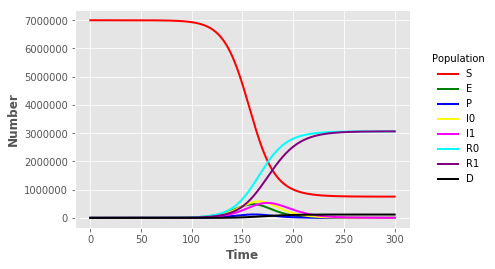

In [73]:
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","E","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","P","",data=sir_out,color="blue",linewidth=2)
rline = plt.plot("t","I0","",data=sir_out,color="yellow",linewidth=2)
rline = plt.plot("t","I1","",data=sir_out,color="magenta",linewidth=2)
rline = plt.plot("t","R0","",data=sir_out,color="cyan",linewidth=2)
rline = plt.plot("t","R1","",data=sir_out,color="purple",linewidth=2)
rline = plt.plot("t","D","",data=sir_out,color="black",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)